In [1]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_fscore_support, precision_recall_curve, roc_auc_score, roc_curve, auc
from sklearn.feature_selection import SelectFromModel

import warnings
warnings.filterwarnings('ignore')


%matplotlib inline


# CONTENTS:
## [HP-LC](#hplc) - A-stretch from a pseudoknotted hairpin interacting with an adjacent stem
## [IP-LC](#iplc) - A-stretch from a pseudoknotted internal loop interacting with an adjacent stem


In [2]:
def SelectTopNFeatures(data, N = 5, draw = True):
    
    best = {}

    for i in range(10):
    
        feature_columns = data.columns[4:-1]

        while len(feature_columns) > N*2:
    
            X = data[feature_columns]
            Y = data['pos']

            sel = SelectFromModel(RandomForestClassifier(class_weight='balanced'))
            sel.fit(X, Y)
                
            feature_columns = X.columns[(sel.get_support())]
    
        X = data[feature_columns]
        Y = data['pos']

        sel = SelectFromModel(RandomForestClassifier(class_weight='balanced'))
        sel.fit(X, Y)
    
        feature_importances = sel.estimator_.feature_importances_.ravel()
        
        for f, s in [(feature_columns[i], feature_importances[i]) for i in np.argsort(feature_importances)]:
            
            if f not in best:
                best[f] = [s,]
            else:
                best[f].append(s)
                
    for f in best:
        best[f] = np.mean(best[f])
    
    if draw:
    
        print('Top-{} features:'.format(N),end=' ')
        print(*[x[0] for x in sorted(list(best.items()),key = lambda x: x[1],reverse=True)][:N],sep=', ')
    
    return [x[0] for x in sorted(list(best.items()),key = lambda x: x[1],reverse=True)][:N]

def KFoldCrossVal(feature_columns, data, K = 4):

    features = np.array(data[feature_columns])
    target   = np.array(data['pos'])

    targets = []
    probas  = []
    
    kfold = KFold(n_splits=K, shuffle=True)

    feature_importances = []

    predicted_proba = np.zeros_like(target, dtype=np.float32)
    predicted = np.zeros_like(target, dtype=np.float32)

    for train_index, test_index in kfold.split(features, target):

        X_train, X_test = features[train_index], features[test_index]
        y_train, y_test = target[train_index], target[test_index]
    
        model = RandomForestClassifier(class_weight='balanced')
    
        model.fit(X_train, y_train)
    
        y_pred = model.predict(X_test)
    
        feature_importances.append(model.feature_importances_)
    
        res = precision_recall_fscore_support(y_test, y_pred)

        predicted[test_index] = y_pred
        
        targets.append(y_test)
        probas.append(model.predict_proba(X_test)[:, 1])
        
    return targets, probas
                
def DrawPRC(targets, probas, pos, neg, draw = True):

    auprc = []
    
    if draw:
    
        fig = plt.figure(figsize=(16, 9))
        ax = fig.add_subplot(1, 1, 1)
        dots = np.arange(0, 1, 0.1)
        ax.scatter(dots, dots)
    
    for i in range(len(targets)):
        
        precision, recall, thresholds = precision_recall_curve(targets[i], probas[i])
        if draw:
            ax.plot(recall, precision)
        
        AUC = auc(recall, precision)
        
        if not np.isnan(AUC):
            auprc.append(AUC)

    if draw:
        
        ax.set_xlabel('Recall',fontsize=18)
        ax.set_ylabel('Precision',fontsize=18)
    

        fig.subplots_adjust(hspace=.5)
        plt.show()
    
        print('# A-stems (positives) = {}'.format(pos))
        print('# Non-interacting (stem, A-stretch) pairs (negatives) = {}'.format(neg))
        print('Positive rate = {} %'.format(round((pos/(pos+neg))*100,2)))
        print('AUPRC = {} %'.format(round(np.mean(auprc)*100,2)))
    
    return auprc
    

In [3]:
ams = pd.read_csv('MLdataset.csv',header=0,sep='\t')
print(ams[ams['pos']==0].shape)
print(ams[ams['pos']==1].shape)

(183298, 292)
(347, 292)


# HP-LC (feature selection on IP-LC) <a class="anchor" id="hplc"></a>

Top-5 features: lr_adedist, al_dist, lr_dist, lr_cytdist, l1t_hp


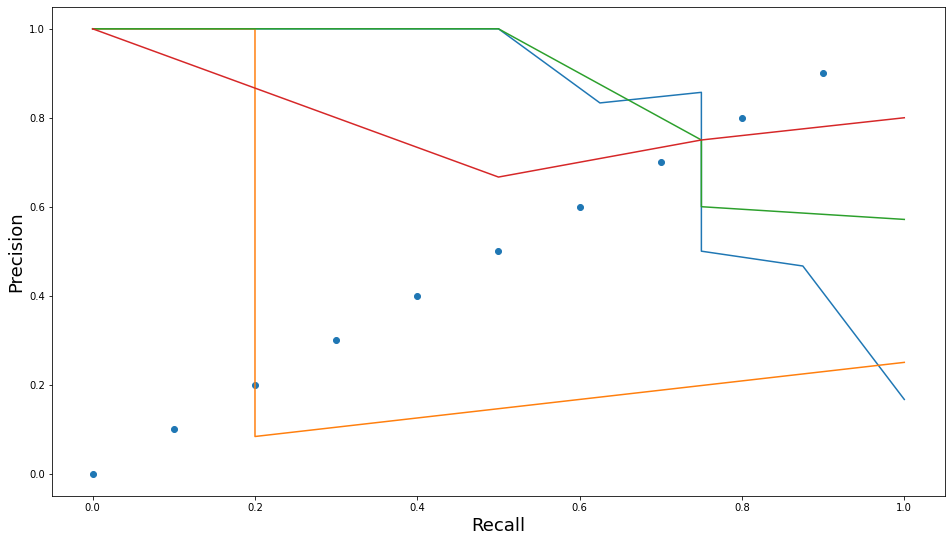

# A-stems (positives) = 21
# Non-interacting (stem, A-stretch) pairs (negatives) = 169
Positive rate = 11.05 %
AUPRC = 70.16 %


In [52]:
data_cv = ams[ams['SecStruct'] == 'HP-LC'] 
data_fs = ams[ams['SecStruct'] == 'IP-LC'] 

neg = data_cv[data_cv['pos']==0].shape[0]
pos = data_cv[data_cv['pos']==1].shape[0]

feature_columns         = SelectTopNFeatures(data_fs)
target, predicted_proba = KFoldCrossVal(feature_columns, data_cv)

auprc = DrawPRC(target, predicted_proba, pos, neg)

In [56]:
auprc = []

for i in range(10):
    target, predicted_proba = KFoldCrossVal(feature_columns, data_cv)
    auprc += DrawPRC(target, predicted_proba, pos, neg, draw = False)
    
print('mean AUPRC = {}'.format(round(np.mean(auprc),2)))
print('AUPRC variance = {}'.format(round(np.var(auprc),2)))

mean AUPRC = 0.73
AUPRC variance = 0.03


# IP-LC (feature selection on HP-LC) <a class="anchor" id="iplc"></a>

Top-5 features: a-1w_eq_r0w, a1w_eq_r1w, ar_rstemdist, a-1t_eq_r-1t, a0t_eq_r1t


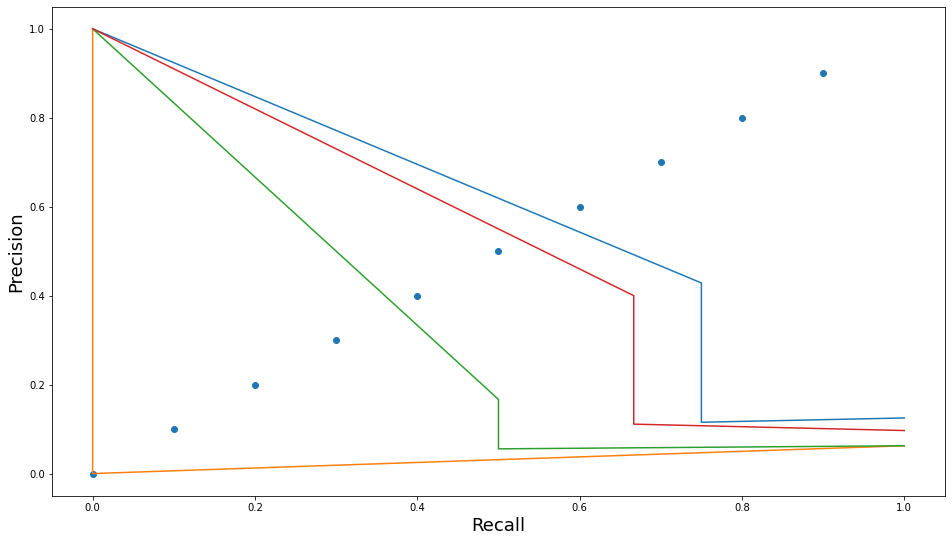

# A-stems (positives) = 11
# Non-interacting (stem, A-stretch) pairs (negatives) = 116
Positive rate = 8.66 %
AUPRC = 35.49 %


In [110]:
data_cv = ams[ams['SecStruct'] == 'IP-LC'] 
data_fs = ams[ams['SecStruct'] == 'HP-LC'] 

neg = data_cv[data_cv['pos']==0].shape[0]
pos = data_cv[data_cv['pos']==1].shape[0]

feature_columns         = SelectTopNFeatures(data_fs)
target, predicted_proba = KFoldCrossVal(feature_columns, data_cv)

auprc = DrawPRC(target, predicted_proba, pos, neg)

In [112]:
auprc = []

for i in range(10):
    target, predicted_proba = KFoldCrossVal(feature_columns, data_cv)
    auprc += DrawPRC(target, predicted_proba, pos, neg, draw = False)
    
print('mean AUPRC = {}'.format(round(np.mean(auprc),2)))
print('AUPRC variance = {}'.format(round(np.var(auprc),2)))

mean AUPRC = 0.43
AUPRC variance = 0.03
